# Plot histograms

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'calibration.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['T', 'm', 'R', 'D']

# Plots
histBinNum = 30 # Histograms
histCenter = True # Center distribution
plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
# Save
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum']

# Filter histograms
histFilter = ['Floorplan.copies:histogram']

histNames = [
    ('Floorplan.copies:histogram', 'Number of copies received by each user in an hear window', 1),
]

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

In [6]:
# Computed
factorsCount = len(factors)
configsCount = len(scalars_wide)//repetitionsCount
print('Configs:', configsCount)
totalSims = configsCount*repetitionsCount


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
pd.set_option('display.max_columns', 100)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Configs: 16


## Load histograms

In [7]:
histograms = df[df.type == 'histogram']
histograms = histograms.assign(qname = histograms.module + '.' + histograms.name)
histograms = histograms[histograms.qname.isin(histFilter)]
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    histograms.loc[histograms.run == r, 'config'] = cfg
    histograms.loc[histograms.run == r, 'repetition'] = rep
    histograms.loc[histograms.run == r, 'binsize'] = histograms.loc[histograms.run == r, 'binedges'].values[0][1] - histograms.loc[histograms.run == r, 'binedges'].values[0][0]
    histograms.loc[histograms.run == r, 'binmin'] = histograms.loc[histograms.run == r, 'binedges'].values[0].min()
    histograms.loc[histograms.run == r, 'binmax'] = histograms.loc[histograms.run == r, 'binedges'].values[0].max()
histograms.sort_values(['config', 'repetition', 'qname'], inplace=True)

for cfg in range(0, configsCount):
    for histname, _, _ in histNames:
        histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binsizelcm'] = np.lcm.reduce(list(map(int, histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binsize'].values.tolist())))
        histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binminall'] = histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binmin'].min()
        histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binmaxall'] = histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binmax'].max()
histograms = histograms[['config', 'repetition', 'qname', 'binmin', 'binmax', 'binsize', 'binedges', 'binvalues', 'binminall', 'binmaxall', 'binsizelcm']]

## Compute means and ranges

In [8]:
def get_values_for_bin(hist, low, high):
    edges = hist['binedges'].values[0]
    values = hist['binvalues'].values[0]
    inbin = []
    lowidx = 0
    highidx = 0
    for edge in edges:
        if edge < low:
            lowidx += 1
        if edge < high:
            highidx += 1
            continue
        break
    minval = math.inf
    maxval = -math.inf
    for i in range(lowidx, highidx):
        if i > len(values) - 1:
            break
        inbin.append(values[i])
        if values[i] < minval:
            minval = values[i]
        if values[i] > maxval:
            maxval = values[i]
    if len(inbin) == 0:
        return (minval, 0, maxval)
    return (minval, sum(inbin) / len(inbin), maxval)
        

cols = ['config']
for histname, _, _ in histNames:
    name = histname[histname.index('.')+1:histname.index(':')]
    cols.append(name + 'Bins')
    cols.append(name + 'MeanValues')
    cols.append(name + 'LowValues')
    cols.append(name + 'HighValues')
data = []
for cfg in range(0, configsCount):
    curdata = [cfg]
    for histname, _, stepMultiplier in histNames:
        binmin = int(histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binminall'].values[0])
        binstep = int(stepMultiplier) * int(histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binsizelcm'].values[0])
        binmax = 1 + int(histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binmaxall'].values[0])
        bins = np.arange(binmin, binmax, binstep)
        totalSize = (binmax - binmin - 1)//binstep
        meanValues = np.zeros(totalSize)
        lowValues = np.full(totalSize, math.inf)
        highValues = np.full(totalSize, -math.inf)
        for rep in range(0, repetitionsCount):
            curHist = histograms[(histograms.config == cfg) & (histograms.qname == histname) & (histograms.repetition == rep)]
            num = 0
            for binlow, binhigh in zip(range(binmin, binmax - 1, binstep), range(binmin + binstep, binmax + binstep, binstep)):
                values = get_values_for_bin(curHist, binlow, binhigh)
                if lowValues[num] > values[0]:
                    lowValues[num] = values[0]
                meanValues[num] += values[1]
                if highValues[num] < values[2]:
                    highValues[num] = values[2]
                num += 1
        for i in range(0, len(meanValues)):
            meanValues[i] = meanValues[i] / repetitionsCount
        curdata.append(bins)
        curdata.append(meanValues)
        curdata.append(lowValues)
        curdata.append(highValues)
    data.append(curdata)
plotdf = pd.DataFrame.from_records(data, columns=cols, index='config')

## Plots

Config 0


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-0-20210205-10:14:34-14521,0.0,2.0,3.0,10.0,1.0


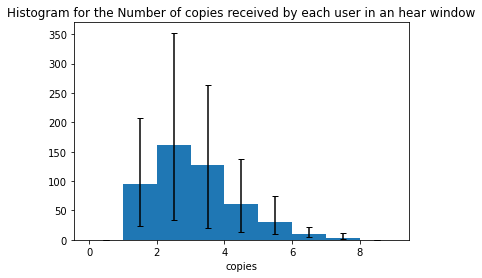

#######################

Config 1


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-40-20210205-10:14:48-14521,1.0,2.0,3.0,10.0,2.0


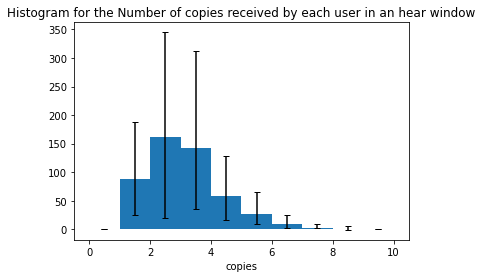

#######################

Config 2


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-10-20210205-10:14:37-14521,2.0,2.0,3.0,25.0,1.0


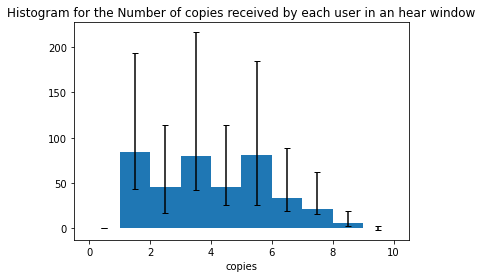

#######################

Config 3


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-50-20210205-10:14:52-14521,3.0,2.0,3.0,25.0,2.0


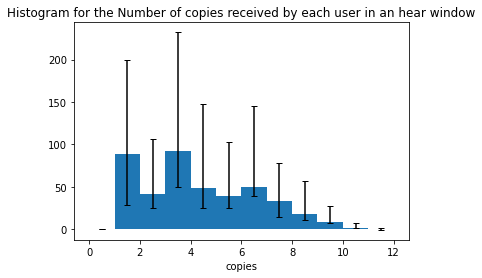

#######################

Config 4


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-20-20210205-10:14:40-14521,4.0,2.0,7.0,10.0,1.0


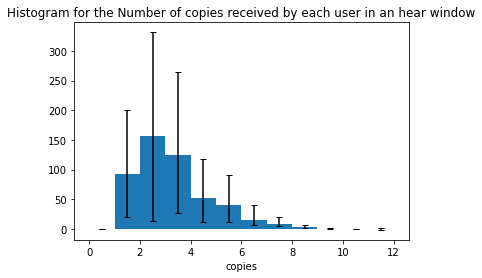

#######################

Config 5


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-60-20210205-10:14:54-14521,5.0,2.0,7.0,10.0,2.0


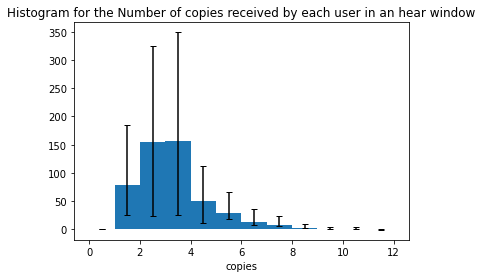

#######################

Config 6


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-30-20210205-10:14:45-14521,6.0,2.0,7.0,25.0,1.0


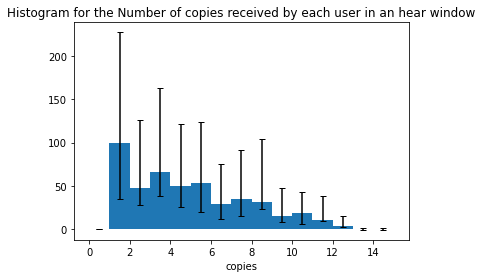

#######################

Config 7


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-70-20210205-10:14:59-14521,7.0,2.0,7.0,25.0,2.0


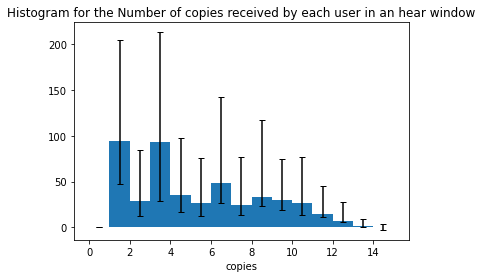

#######################

Config 8


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-80-20210205-10:15:02-14521,8.0,6.0,3.0,10.0,3.0


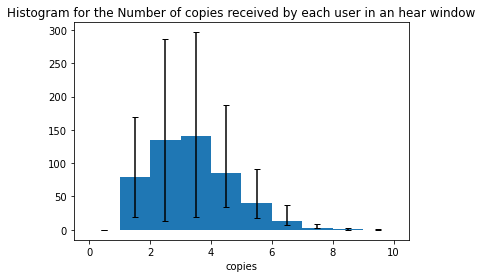

#######################

Config 9


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-120-20210205-10:15:15-14521,9.0,6.0,3.0,10.0,6.0


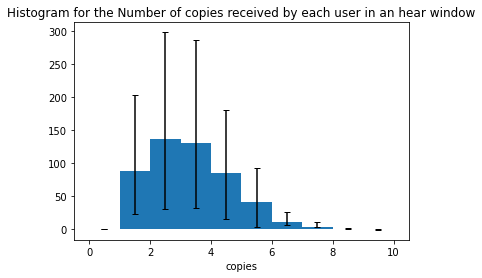

#######################

Config 10


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-90-20210205-10:15:05-14521,10.0,6.0,3.0,25.0,3.0


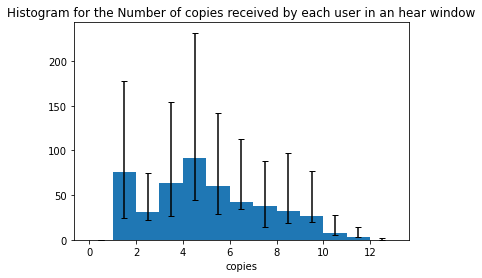

#######################

Config 11


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-130-20210205-10:15:18-14521,11.0,6.0,3.0,25.0,6.0


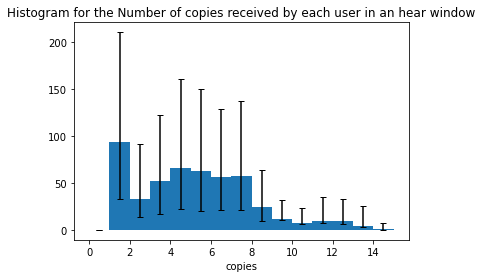

#######################

Config 12


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-100-20210205-10:15:07-14521,12.0,6.0,7.0,10.0,3.0


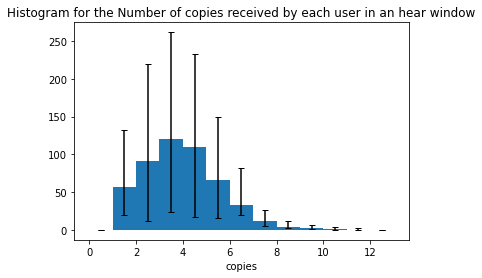

#######################

Config 13


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-140-20210205-10:15:20-14521,13.0,6.0,7.0,10.0,6.0


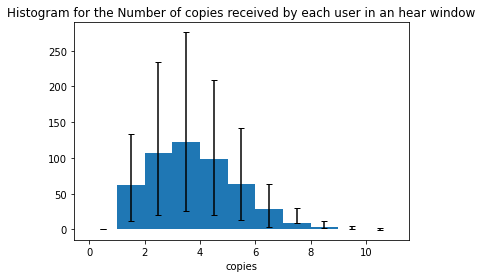

#######################

Config 14


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-110-20210205-10:15:11-14521,14.0,6.0,7.0,25.0,3.0


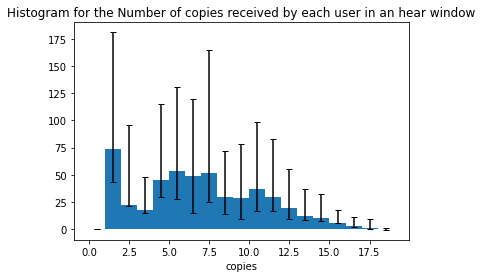

#######################

Config 15


qname,config,T,m,R,D
run,,,,,
HighDensityCalibration-150-20210205-10:15:25-14521,15.0,6.0,7.0,25.0,6.0


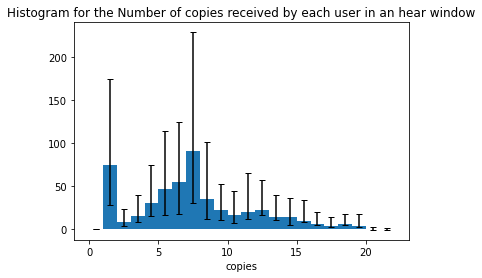

#######################



In [9]:
for cfg, hist in plotdf.iterrows():
    for histName, histDesc, _ in histNames:
        print('Config ' + str(cfg))
        display(scalars_wide.loc[(scalars_wide.repetition == 0) & (scalars_wide.config == cfg)][['config', *factors]])
        name = histName[histName.index('.')+1:histName.index(':')]
        bins = hist[name + 'Bins']
        means = hist[name + 'MeanValues']
        lows = hist[name + 'LowValues']
        highs = hist[name + 'HighValues']
        bincenters = 0.5*(bins[1:]+bins[:-1])
        ranges = [x for x in zip(lows, highs)]
        ranges = np.array(ranges).T
        plt.bar(bincenters, means, width=1, yerr=ranges, error_kw={'capsize': 3})
        plt.title('Histogram for the ' + histDesc)
        plt.xlabel(name)
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(histName) + '-' + str(cfg) + '-perfplot.png')
        plt.show()
        print('#######################')
        print()